In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [8]:
%load_ext autoreload
%autoreload 2

import datetime
from collections import defaultdict

import numpy as np
import scipy

import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, PolytopeFeasibility
from methods import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def train_loop(p: int, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    n = 200
    d = 100
    
    # dataset
    data = np.random.rand(n, d) * 2 - 1
    w_star =  np.random.rand(d) * 2 - 1
    target = data @ w_star
    
    # parameters
    w = np.ones(d)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = PolytopeFeasibility(data, target, p)
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)

        optim.step(oracle=loss_function)

        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["time"].append(time)
    
    return history

In [55]:
hyperparams = {
    "DampedNewton": {"lr": -1.0},
    "AICN": {"L_est": 1.0},
    "RootNewton": {"q": 2.0, "L_est": 0.5},
    "SimpliReg": {"beta": 0.001, "sigma": 1.0},
    "GradientMethod": {"L_est": 1.0}, 
    "UniversalNewton": {"sigma_0": 1.0, "c": 3.5},
}

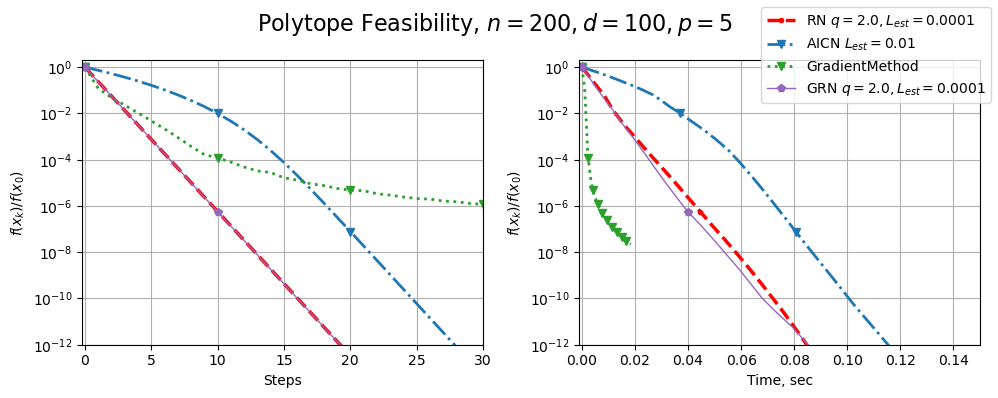

In [101]:
np.random.seed(0)

n_steps = 100
p = 5

histories = []
labels = []

# Root Newton
q = 2.0
L_est = 0.0001
hist = train_loop(p=p, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = 0.01
hist = train_loop(p=p, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop(p=p, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GradientMethod")

# GradRegNewton
q = 2.0
L_est = 0.0001
hist = train_loop(p=p, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

utils.plotter(histories=histories, 
        labels=labels,
        colors=["red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["--", "-.", ":", "-"],
        linewidths=[2.5, 2.0, 2.0, 1.0],
        markers=[".", "v", "v", "p"],
        f_star=0.0, 
        suptitle=r"Polytope Feasibility, $n={0}, d={1}, p={2}$".format(200, 100, p),
        threshold=1e-12,
        xlims=((-0.2, 30), (-0.001, 0.15)),
        filename=f"plots/polytope_rn_p_{p}.pdf")

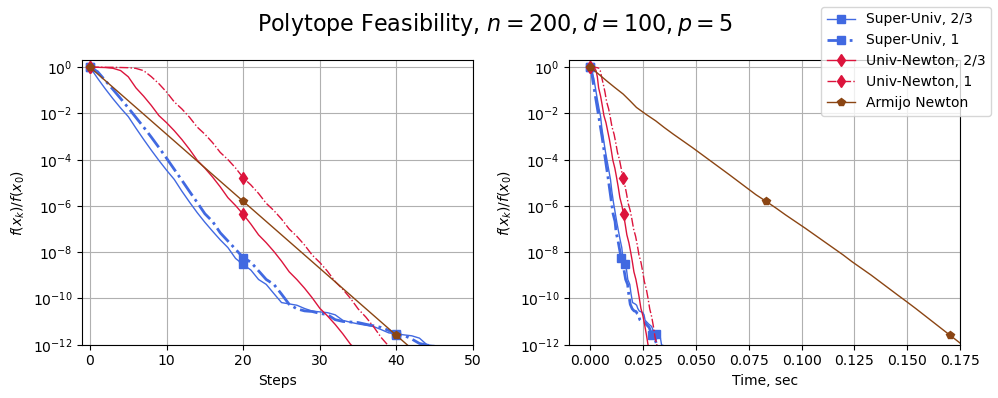

In [82]:
np.random.seed(0)


n_steps = 200
p = 5

histories = []
labels = []

# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):
    hist = train_loop(p=p, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, {0}".format(l))

# Universal Newton
sigma_0 = hyperparams["UniversalNewton"]["sigma_0"]
c = hyperparams["UniversalNewton"]["c"]
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(p=p, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, {0}".format(l))
    
# Universal Newton Armijo 
hist = train_loop(p=p, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
histories.append(hist)
labels.append("Armijo Newton")

utils.plotter(histories=histories, 
    labels=labels,
    colors=["royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
    linestyles=["-", "-.", "-", "-.", "-"],
    linewidths=[1.0, 2.0, 1.0, 1.0, 1.0],
    markers=["s", "s", "d", "d", "p"],
    f_star=0.0, 
    suptitle=r"Polytope Feasibility, $n={0}, d={1}, p={2}$".format(200, 100, p),
    threshold=1e-12,
    xlims=((-1.0, 50), (-0.01, 0.175)),
    filename=f"plots/polytope_univ_p_{p}.pdf")